In [570]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from fitter import Fitter
from scipy import signal
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import ADFTest
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
sns.set_style('darkgrid')
# import arviz as az
# import pymc3 as pm
# from theano import tensor as tt
# from fitter import Fitter, get_common_distributions, get_distributions
# import mean_squared_error
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.metrics import accuracy_score,confusion_matrix
# from pandas.plotting import lag_plot
# from pmdarima.arima import auto_arima
%matplotlib inline
# import shap

In [571]:
os.chdir('G:/My Drive/To_Do/MMM/Raw_Hain_Data/Pivot')

In [572]:
# smd_pivot = pd.read_csv('smd_pivot.csv')
# ts_pivot = pd.read_csv('ts_pivot.csv')
# ct = pd.read_csv('ct_spend.csv') # need information on revenue or impressions
dm_pivot = pd.read_csv('dm_Robyn_pivot.csv')

In [573]:
df = dm_pivot
print(df)

          DATE  audio_S   audio_I  onlinedisplay_S  onlinedisplay_I  \
0    3/28/2021  13193.0  573044.0            16539          1441508   
1     4/4/2021   5654.0  245590.0            11046           917669   
2    4/11/2021   5284.0  190527.0             5979           456890   
3    4/18/2021   5627.0  205508.0             5727           440490   
4    4/25/2021   4849.0  179395.0             5005           391257   
5     5/2/2021   4106.0  149209.0             4566           347095   
6     5/9/2021   4788.0  169530.0             5991           467989   
7    5/16/2021   4271.0  169451.0             5606           441726   
8    5/23/2021   5459.0  224790.0             5083           414955   
9    5/30/2021   2254.0   94336.0             4053           365003   
10    6/6/2021   4544.0  184465.0             9497           892804   
11   6/13/2021   5008.0  206610.0            10050           950490   
12   6/20/2021   2345.0   95231.0             4741           457753   
13   6

In [574]:
def missing_values(df):
    segment = [var for var in df.columns if df[var].dtype == 'O']
    print('There are {} variables\n'.format(len(segment)))
    print('The variables are :\n\n', segment)
    print('The percentage missing of each of the variables is:\n')
    print(df[segment].isnull().sum() * 100/ len(df))
    print('The count of non-nulls for each of the variables is:\n')
    missing = df.select_dtypes(include=object)
    missing.info()

In [575]:
def dickey_fuller(df):
    adf_test = ADFTest(alpha = .05)
    print('Because the ADF is smaller than the given alpha, the null hypothesis is false,'
          'and it is most likely not stationery.')
    result = adf_test.should_diff(df['revenue'])
    return result

In [576]:
def unique(df):
    segment = [var for var in df.columns if df[var].dtype == 'O']
    print('There are {} numerical/continuous variables\n'.format(len(segment)))
    print('The numerical/continuous variables are :\n\n', segment)
    print(df[segment].isnull().sum() / len(df))
    df.info()
    df.describe()
    print(df.nunique())

In [577]:
def summary(df):
    print(missing_values(df))
    print(dickey_fuller(df))
    print(unique(df))

In [578]:
summary(df)

There are 1 variables

The variables are :

 ['DATE']
The percentage missing of each of the variables is:

DATE    0.0
dtype: float64
The count of non-nulls for each of the variables is:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    45 non-null     object
dtypes: object(1)
memory usage: 488.0+ bytes
None
Because the ADF is smaller than the given alpha, the null hypothesis is false,and it is most likely not stationery.
(0.04346214739117136, False)
There are 1 numerical/continuous variables

The numerical/continuous variables are :

 ['DATE']
DATE    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             45 non-null     object 
 1   audio_S          13 non-null     float

In [579]:
df = df.drop(['ott_S', 'ott_I', 'audio_S', 'audio_I',
              'tiktok_S', 'tiktok_I'], axis=1)
df.nunique()

DATE               45
onlinedisplay_S    35
onlinedisplay_I    41
onlinevideo_S      29
onlinevideo_I      29
paidsearch_S       30
paidsearch_I       30
social_S           35
social_I           35
revenue            41
dtype: int64

Explain the decisions to drop

Understand what the numbers mean and at which level their dangerous,

In [580]:
temp_week = pd.DataFrame()
temp_week['WEEK'] = df['DATE']

,onlinedisplay_S,onlinedisplay_I,onlinevideo_S,onlinevideo_I,paidsearch_S,paidsearch_I,social_S,social_I,revenue
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.782222,0.787778,0.524444,0.644444,0.695556,0.715556,0.725556,0.714444,0.832222
std,0.142897,0.163231,0.256569,0.199944,0.236120,0.218867,0.198942,0.235802,0.142984
min,0.590000,0.490000,0.260000,0.420000,0.260000,0.320000,0.410000,0.260000,0.550000
25%,0.710000,0.700000,0.320000,0.480000,0.660000,0.700000,0.660000,0.660000,0.740000
50%,0.730000,0.780000,0.490000,0.660000,0.730000,0.730000,0.700000,0.710000,0.910000
75%,0.910000,0.930000,0.590000,0.740000,0.810000,0.790000,0.920000,0.930000,0.930000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


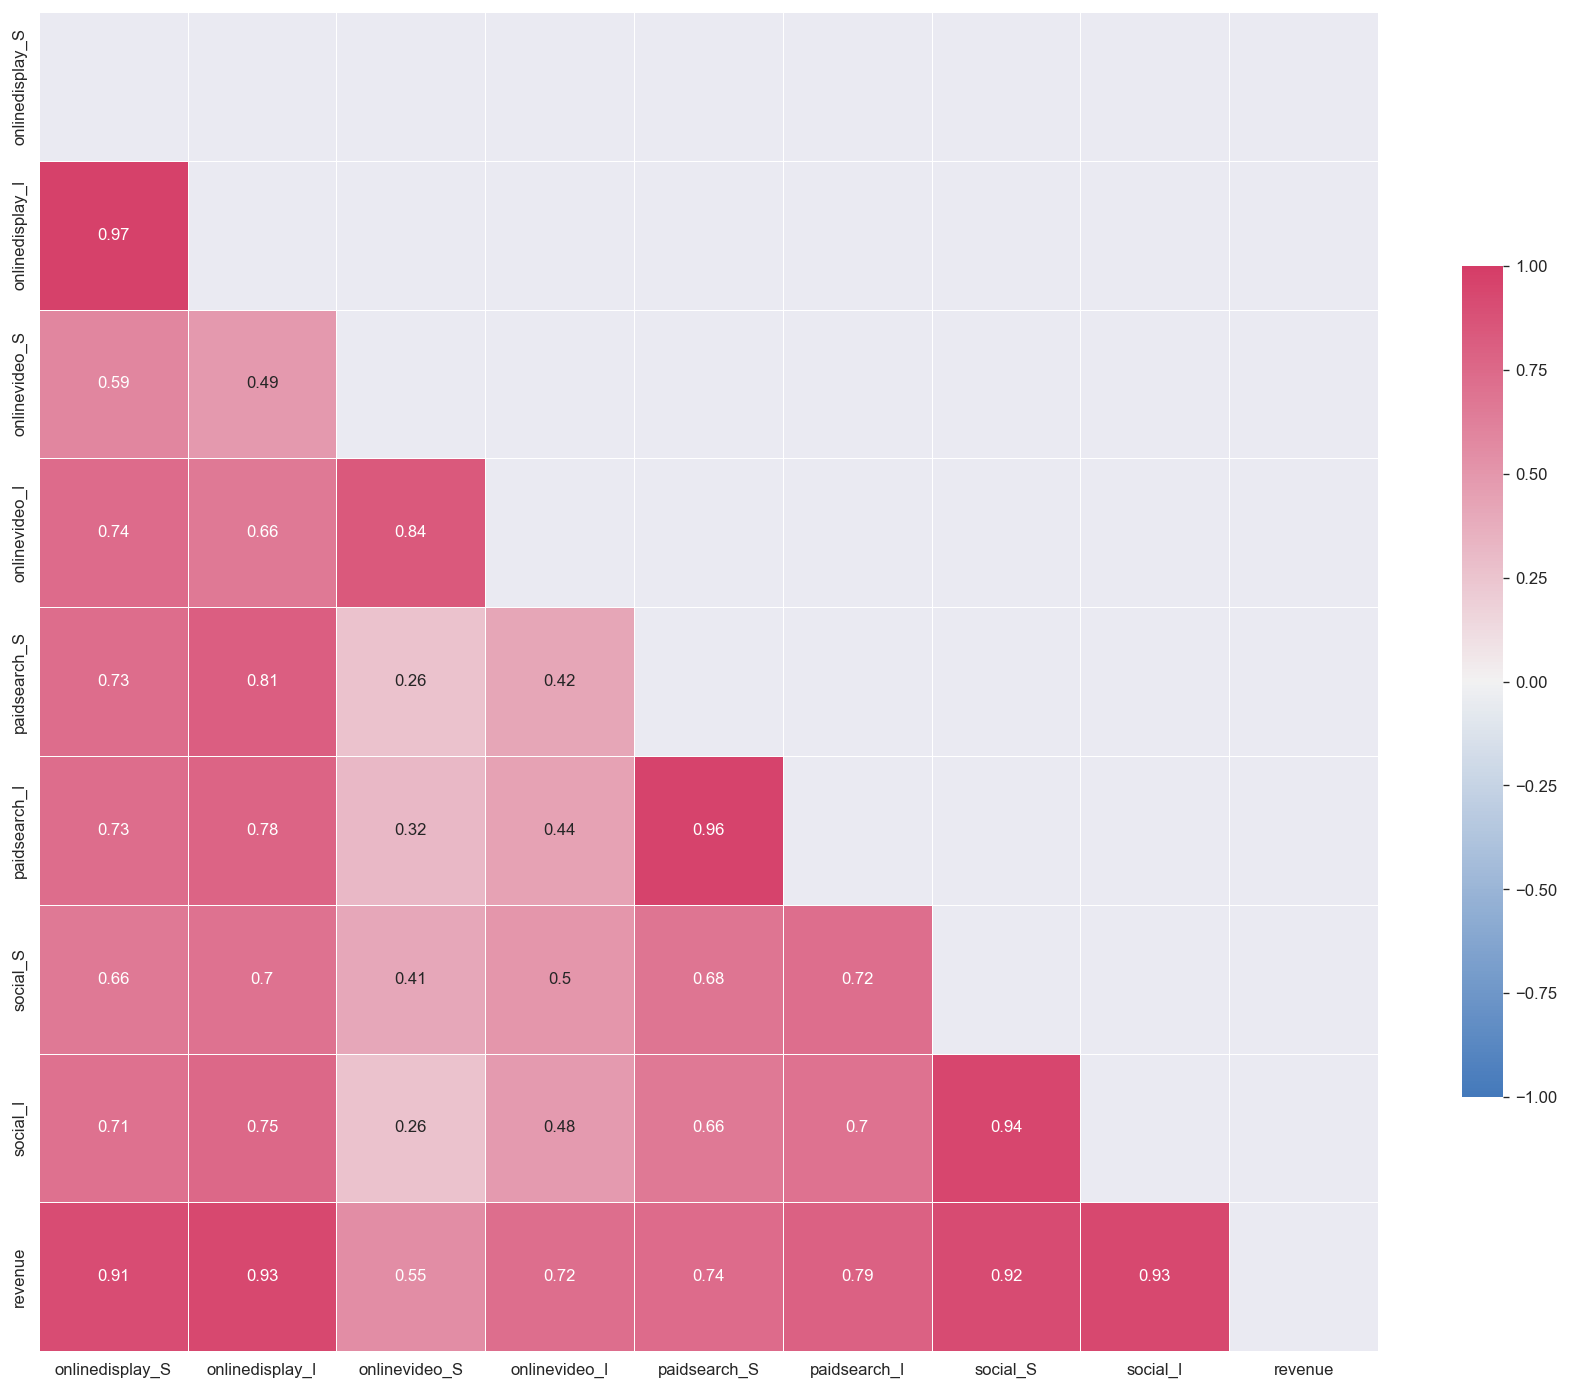

In [581]:
temp_dm = df[['onlinedisplay_S', 'onlinedisplay_I', 'onlinevideo_S',
              'onlinevideo_I', 'paidsearch_S', 'paidsearch_I', 'social_S',
              'social_I', 'revenue']]
corr = temp_dm.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

<AxesSubplot: xlabel='revenue', ylabel='Density'>

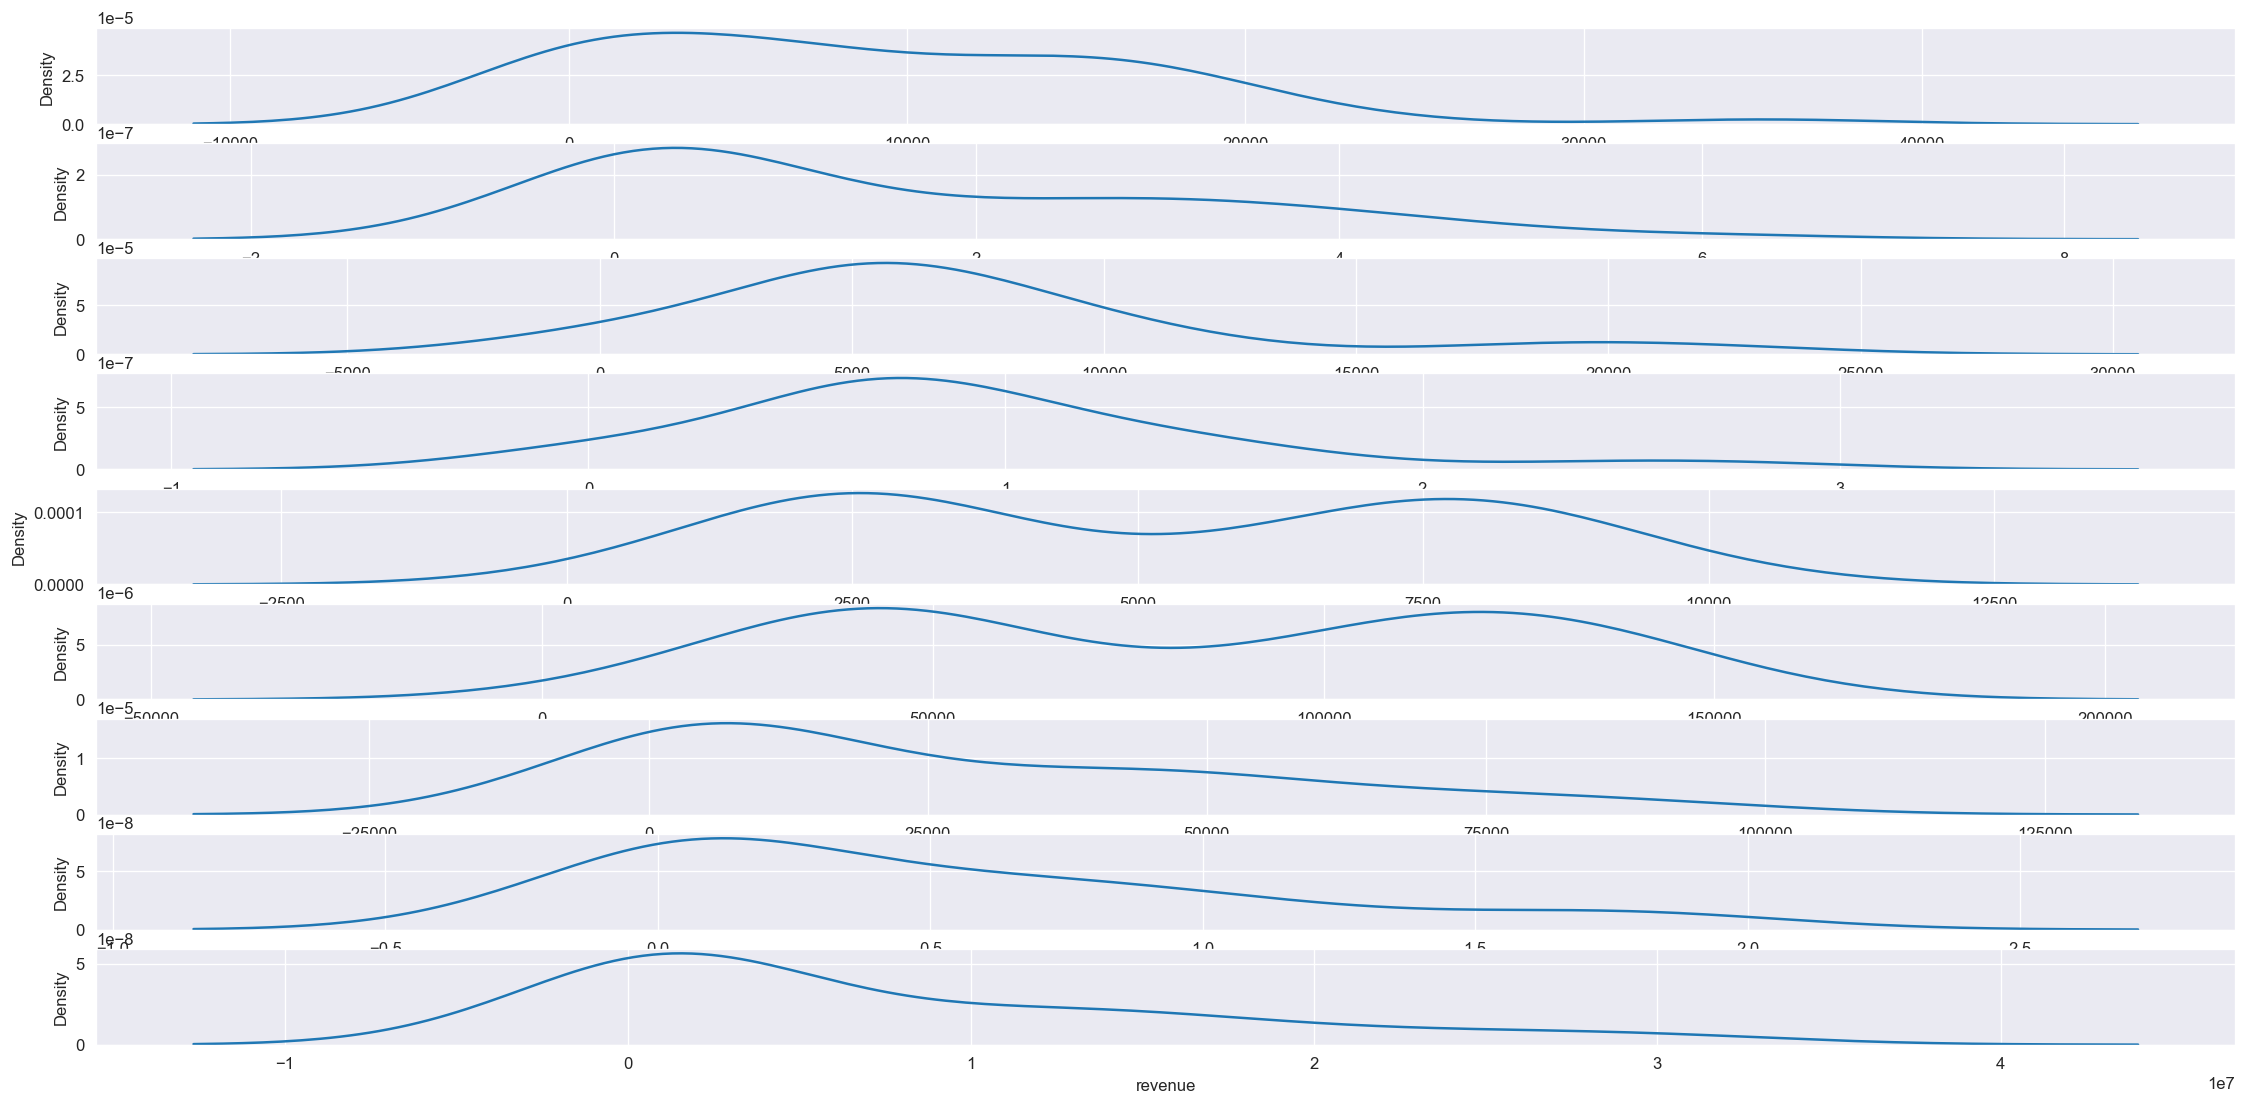

In [582]:
figure, axes = plt.subplots(9, 1, figsize=(23, 11))
sns.kdeplot(ax=axes[0], x='onlinedisplay_S', data=df)
sns.kdeplot(ax=axes[1], x='onlinedisplay_I', data=df)
sns.kdeplot(ax=axes[2], x='onlinevideo_S', data=df)
sns.kdeplot(ax=axes[3], x='onlinevideo_I', data=df)
sns.kdeplot(ax=axes[4], x='paidsearch_S', data=df)
sns.kdeplot(ax=axes[5], x='paidsearch_I', data=df)
sns.kdeplot(ax=axes[6], x='social_S', data=df)
sns.kdeplot(ax=axes[7], x='social_I', data=df)
sns.kdeplot(ax=axes[8], x='revenue', data=df)

Selecting from the most likely distributions of the data,
finds the most likely distribution for the data, its parameters,
and is useful for any data transformations. Discover the best
interpretation of the distributions.

In [583]:
temp_dm = df[['onlinedisplay_S', 'onlinedisplay_I', 'onlinevideo_S',
              'onlinevideo_I', 'paidsearch_S', 'paidsearch_I', 'social_S',
              'social_I', 'revenue']]
dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in temp_dm:
    dist_test = temp_dm[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 45.87it/s]


onlinedisplay_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma       3.570492e-07  2314.849345 -827.922474     inf      0.313820   
expon       5.244874e-07  2222.872156 -814.424485     inf      0.244444   
norm        5.793021e-07  2279.987467 -809.951366     inf      0.131807   
cauchy      5.915711e-07  2275.965036 -809.008267     inf      0.207317   
uniform     6.056248e-07  2098.282318 -807.951720     inf      0.407924   

            ks_pvalue  
gamma    1.946967e-04  
expon    7.472312e-03  
norm     3.815620e-01  
cauchy   3.568311e-02  
uniform  2.777649e-07  
{'gamma': {'a': 0.5334487300201423, 'loc': -5.432003170115127e-22, 'scale': 10550.26024878824}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 40.98it/s]


onlinedisplay_I
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma       1.156552e-11  3431.487626 -1293.114521     inf      0.283750   
expon       1.804661e-11  3249.708419 -1276.899324     inf      0.244383   
cauchy      1.997143e-11  3392.864661 -1272.338804     inf      0.302194   
norm        2.143809e-11  3250.198691 -1269.149831     inf      0.231571   
uniform     2.167140e-11  3128.425849 -1268.662739     inf      0.412041   

            ks_pvalue  
gamma    1.065121e-03  
expon    7.493266e-03  
cauchy   3.838834e-04  
norm     1.324179e-02  
uniform  1.993980e-07  
{'gamma': {'a': 0.5710084773411181, 'loc': -4.726927081958535e-21, 'scale': 1279896.861335139}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 94.34it/s]


onlinevideo_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
cauchy      6.808150e-07  2231.837357 -521.232785     inf      0.172367   
gamma       8.382080e-07  2100.655011 -511.592316     inf      0.191480   
norm        8.528466e-07  2121.087456 -514.474109     inf      0.202324   
expon       8.883478e-07  2096.064719 -513.250603     inf      0.302624   
uniform     9.477982e-07  2007.826995 -511.307254     inf      0.418813   

         ks_pvalue  
cauchy    0.299246  
gamma     0.194417  
norm      0.149033  
expon     0.006199  
uniform   0.000028  
{'cauchy': {'loc': 5385.4967875186385, 'scale': 1559.6063773872481}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 86.21it/s]


onlinevideo_I
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
cauchy      6.328032e-11  3157.596171 -799.736927     inf      0.167243   
gamma       6.729615e-11  3063.009804 -794.489871     inf      0.184595   
norm        6.770160e-11  3086.673323 -797.710866     inf      0.157235   
expon       7.141584e-11  3054.165220 -796.108571     inf      0.324405   
uniform     7.391521e-11  2970.787370 -795.076601     inf      0.384790   

         ks_pvalue  
cauchy    0.333134  
gamma     0.228357  
norm      0.406402  
expon     0.002604  
uniform   0.000166  
{'cauchy': {'loc': 732262.6360080556, 'scale': 243362.52507049876}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 52.63it/s]


paidsearch_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
uniform         0.000005  1816.252030 -461.775541     inf      0.216173   
expon           0.000005  1877.717918 -460.441233     inf      0.197998   
gamma           0.000005  1855.347986 -456.264169     inf      0.236039   
norm            0.000005  1853.317753 -459.661289     inf      0.237493   
cauchy          0.000005  1916.443042 -458.635400     inf      0.177867   

         ks_pvalue  
uniform   0.103826  
expon     0.166004  
gamma     0.059228  
norm      0.056731  
cauchy    0.265635  
{'uniform': {'loc': 939.0, 'scale': 8615.0}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 48.08it/s]


paidsearch_I
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
uniform     3.031168e-08  2347.325041 -614.585509     inf      0.202247   
expon       3.173537e-08  2408.795756 -613.208550     inf      0.217325   
gamma       3.233512e-08  2388.586669 -609.245687     inf      0.241533   
norm        3.233531e-08  2386.595587 -612.646704     inf      0.241713   
cauchy      3.322010e-08  2449.135271 -611.836849     inf      0.197368   

         ks_pvalue  
uniform   0.149320  
expon     0.100641  
gamma     0.050258  
norm      0.049985  
cauchy    0.168599  
{'uniform': {'loc': 18516.0, 'scale': 122593.0}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 46.30it/s]


social_S
         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma       8.295990e-08  2407.181239 -684.442937     inf      0.192548   
expon       8.501548e-08  2388.346606 -687.141624     inf      0.267539   
cauchy      9.115879e-08  2529.084281 -684.699689     inf      0.287947   
uniform     9.584471e-08  2291.282305 -682.945267     inf      0.396096   
norm        9.599694e-08  2377.401312 -682.889720     inf      0.239285   

         ks_pvalue  
gamma     0.130453  
expon     0.010580  
cauchy    0.004606  
uniform   0.000018  
norm      0.030104  
{'gamma': {'a': 0.754311345964199, 'loc': -4.69218623618587e-21, 'scale': 33482.36175175519}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 46.29it/s]


social_I
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma       1.466235e-12  3577.318526 -1067.462448     inf      0.260604   
expon       1.696609e-12  3455.236264 -1065.910115     inf      0.314522   
cauchy      1.925616e-12  3598.302800 -1061.478625     inf      0.319282   
uniform     2.037482e-12  3352.198094 -1059.502206     inf      0.397637   
norm        2.037548e-12  3440.283999 -1059.501081     inf      0.220809   

         ks_pvalue  
gamma     0.013831  
expon     0.001414  
cauchy    0.001131  
uniform   0.000017  
norm      0.055881  
{'gamma': {'a': 0.8544834667249374, 'loc': -5.599278432845403e-23, 'scale': 3655539.81946034}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 43.10it/s]

revenue
         sumsquare_error          aic          bic  kl_div  ks_statistic  \
gamma       3.285597e-13  3978.761049 -1453.362421     inf      0.437447   
expon       6.876800e-13  3587.623354 -1423.931861     inf      0.266895   
cauchy      7.013429e-13  3797.035645 -1423.046562     inf      0.306300   
norm        8.461192e-13  3574.951086 -1414.601715     inf      0.275315   
uniform     8.578153e-13  3456.160352 -1413.983930     inf      0.485383   

            ks_pvalue  
gamma    2.361764e-08  
expon    2.549473e-03  
cauchy   3.029925e-04  
norm     1.660212e-03  
uniform  2.748920e-10  
{'gamma': {'a': 0.2541383466522374, 'loc': -3.7891205254781435e-21, 'scale': 6313709.556282228}}


Get the best interpretation of the data and the plot

Text(0.5, 1.0, 'Sales Detrended')

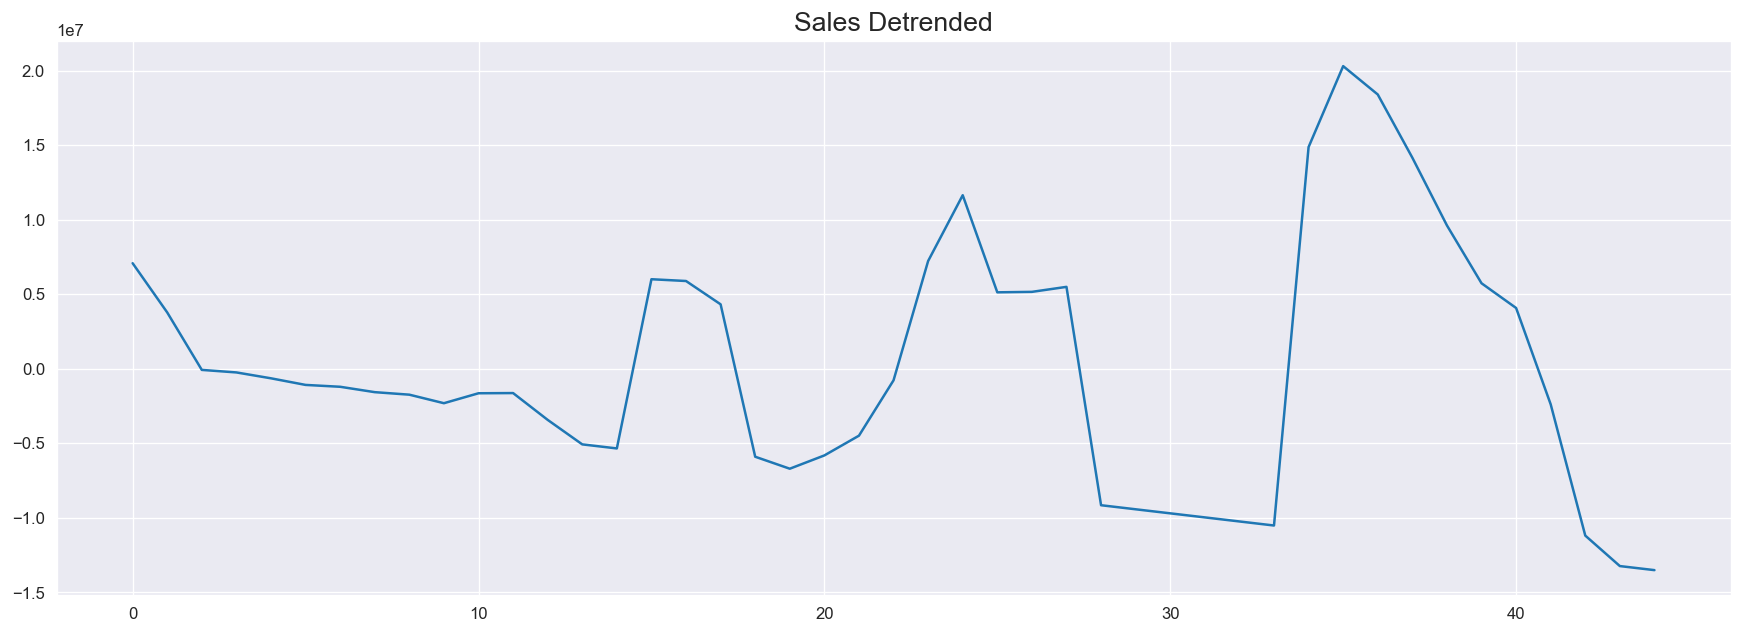

In [584]:
detrended = signal.detrend(df['revenue'].values)
plt.rcParams.update({'figure.figsize': (18,6)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

Validate whether or not the data is autocorrelated

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

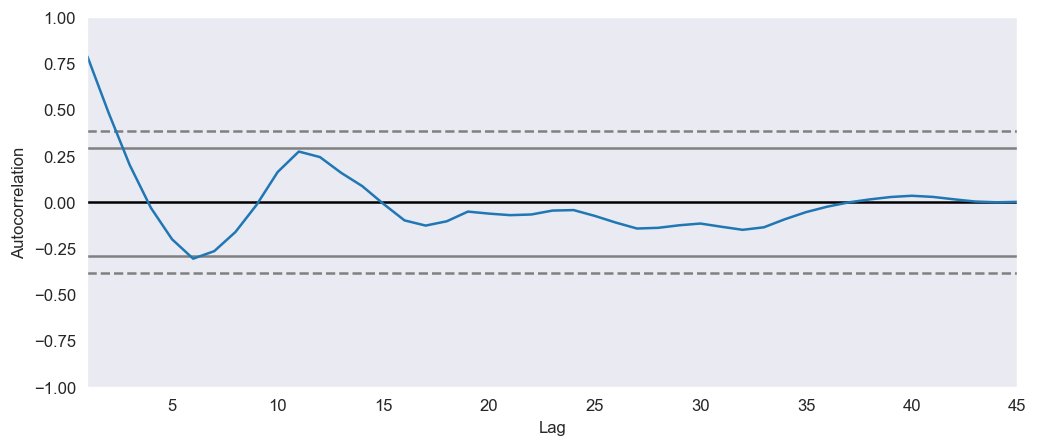

In [585]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df['revenue'].tolist())

In [586]:
# df.to_csv('ct.csv', encoding='utf-8', index=False)

Figure out how to unscale the KNN data

In [587]:
# KNN Imputation
df_knn = df.filter(['onlinedisplay_S', 'onlinedisplay_I', 'onlinevideo_S',
                    'onlinevideo_I', 'paidsearch_S', 'paidsearch_I', 'social_S',
                    'social_I', 'revenue'], axis=1).copy()

In [588]:
# Define scaler to set values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=12, weights='distance', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

Read through shap documentation, figure out how to better visualize and analyze data

In [590]:
df = df.drop(columns='DATE')
imputer = KNNImputer(n_neighbors=10, metric='nan_euclidean')
imputed_KNN = imputer.fit_transform(df)
imputed_KNN = pd.DataFrame(imputed_KNN, columns = df.columns)
KNN_imputation = pd.concat([imputed_KNN, temp_week], axis=1)

In [591]:
imputed_KNN = pd.DataFrame(imputed_KNN, columns = df.columns)
KNN_imputation = pd.concat([imputed_KNN, temp_week], axis=1)

Mice is the most robust imputation method, but it still leaves some zeros in the data that need to be fixed for Robyn.

In [592]:
df_mice = df.filter(['onlinedisplay_S', 'onlinedisplay_I', 'onlinevideo_S',
                     'onlinevideo_I', 'paidsearch_S', 'paidsearch_I', 'social_S',
                     'social_I', 'revenue'], axis=1).copy()

mice_estimator = IterativeImputer(estimator=linear_model.BayesianRidge(), sample_posterior=True, max_iter=40,
                                n_nearest_features=4, imputation_order='arabic', min_value=500)
df_mice_imputed = pd.DataFrame(mice_estimator.fit_transform(df_mice), columns=df_mice.columns)
imputated_mice = pd.concat([df_mice_imputed, temp_week], axis=1)

In [ ]:
imputated_mice.to_csv('mice_1.csv', encoding='utf-8', index=False)
KNN_imputation.to_csv('KNN_1.csv', encoding='utf-8', index=False)